# Housing Project

**Author:** Ron Lodetti Jr.

<img src="./images/housing.jpg">

## Overview
This project analyzes housing data from [King County Assessor Data](https://info.kingcounty.gov/assessor/DataDownload/default.aspx) to help a startup create an app to find and recommend housing deals. Statistical analysis of this data shows that square footage of living space, whether or not the property is on a waterfront, and its zip code are the best predictors of sale price. Further data collection and analysis should be done to develop a more reliable model.

## Business Problem
A new startup is developing an app to help consumers find the best deals on home purchases. The company would like to beta test in King County, Washington before expanding into other markets. My task is to analyze the housing data to find what features of a property best determine the sale price. The company will use this information to recommend properties to customers which are priced below the model's price.

## Data Understanding

In [1]:
# Import standard packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from scipy import stats

In [2]:
# Loading the datasets.
orig_df = pd.read_csv('data/original.csv')
res = pd.read_csv('data/residential.csv', low_memory=False)
parcel = pd.read_csv('data/parcel.csv', low_memory=False)
sales = pd.read_csv('data/sales.csv', low_memory=False)
ods = pd.read_csv('data/open_datasoft.csv')
pd.set_option("mode.chained_assignment", None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Original Dataset
For this project I used the dataset provided by the Flatiron School which comes from [King County Assessor Data](https://info.kingcounty.gov/assessor/DataDownload/default.aspx) 

Here are the variables I used, including their descriptions:
* **id** - Unique identifier for a house
* **date** - Date house was sold
* **price** - Sale price (prediction target)
* **bedrooms** - Number of bedrooms
* **bathrooms** - Number of bathrooms
* **sqft_living** - Square footage of living space in the home
* **sqft_lot** - Square footage of the lot
* **floors** - Number of floors (levels) in house
* **waterfront** - Whether the house is on a waterfront
* **greenbelt** - Whether the house is adjacent to a green belt
* **nuisance** - Whether the house has traffic noise or other recorded nuisances
* **view** - Quality of view from house
* **condition** - How good the overall condition of the house is. Related to maintenance of house.
* **grade** - Overall grade of the house. Related to the construction and design of the house.
* **sqft_basement** - Square footage of the basement
* **yr_built** - Year when house was built
* **yr_renovated** - Year when house was renovated
* **address** - The street address

In [3]:
orig_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  sqft_basement  30155 non-null  int64  
 15  yr_built       30155 non-null  int64  
 16  yr_renovated   30155 non-null  int64  
 17  address        30155 non-null  object 
dtypes: flo

In [4]:
orig_df.head(3)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,sqft_basement,yr_built,yr_renovated,address
0,7399300360,5/24/2022,675000.0,4,1.0,1180,7140,1.0,NO,NO,NO,NONE,Good,7 Average,0,1969,0,"2102 Southeast 21st Court, Renton, Washington ..."
1,8910500230,12/13/2021,920000.0,5,2.5,2770,6703,1.0,NO,NO,YES,AVERAGE,Average,7 Average,1570,1950,0,"11231 Greenwood Avenue North, Seattle, Washing..."
2,1180000275,9/29/2021,311000.0,6,2.0,2880,6156,1.0,NO,NO,NO,AVERAGE,Average,7 Average,1580,1956,0,"8504 South 113th Street, Seattle, Washington 9..."


### Additional Datasets
I also incorporated additional datasets from [King County Assessor Data](https://info.kingcounty.gov/assessor/DataDownload/default.aspx): 
* Residential Building
* Parcel
* Real Property Sales

Each of these datasets includes a `Major` and `Minor` column which have six and four characters respectively and may have leading zeros. When concatenated they create a unique `id` which will be used for merging.

In [5]:
res.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 524552 entries, 0 to 524551
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Major            524552 non-null  int64  
 1   Minor            524552 non-null  int64  
 2   ZipCode          472502 non-null  object 
 3   Stories          524552 non-null  float64
 4   BldgGrade        524552 non-null  int64  
 5   SqFtTotLiving    524552 non-null  int64  
 6   SqFtTotBasement  524552 non-null  int64  
 7   SqFtFinBasement  524552 non-null  int64  
 8   Bedrooms         524552 non-null  int64  
 9   BathFullCount    524552 non-null  int64  
 10  YrBuilt          524552 non-null  int64  
 11  YrRenovated      524552 non-null  int64  
 12  Condition        524552 non-null  int64  
dtypes: float64(1), int64(11), object(1)
memory usage: 52.0+ MB


In [6]:
res.head(3)

,Major,Minor,ZipCode,Stories,BldgGrade,SqFtTotLiving,SqFtTotBasement,SqFtFinBasement,Bedrooms,BathFullCount,YrBuilt,YrRenovated,Condition
0,12603,9624,98133,1.0,8,1810,720,420,3,2,1982,0,3
1,12603,9625,98177,1.5,7,4340,2320,1740,3,2,1994,0,3
2,12603,9628,98133,1.0,7,1800,660,660,4,1,1982,0,3


In [7]:
parcel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 622667 entries, 0 to 622666
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Major                622667 non-null  int64 
 1   Minor                622667 non-null  int64 
 2   PropType             622667 non-null  object
 3   SqFtLot              622667 non-null  int64 
 4   MtRainier            622667 non-null  int64 
 5   Olympics             622667 non-null  int64 
 6   Cascades             622667 non-null  int64 
 7   Territorial          622667 non-null  int64 
 8   SeattleSkyline       622667 non-null  int64 
 9   PugetSound           622667 non-null  int64 
 10  LakeWashington       622667 non-null  int64 
 11  LakeSammamish        622667 non-null  int64 
 12  SmallLakeRiverCreek  622667 non-null  int64 
 13  OtherView            622667 non-null  int64 
 14  WfntLocation         622667 non-null  int64 
 15  TrafficNoise         622667 non-nu

In [8]:
parcel.head(3)

,Major,Minor,PropType,SqFtLot,MtRainier,Olympics,Cascades,Territorial,SeattleSkyline,PugetSound,LakeWashington,LakeSammamish,SmallLakeRiverCreek,OtherView,WfntLocation,TrafficNoise,AirportNoise,PowerLines,OtherNuisances,AdjacentGreenbelt
0,714760,85,R,16693,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,N
1,739920,210,R,8686,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,N
2,510140,8598,R,6434,0,0,0,0,0,0,0,0,0,0,0,0,0,N,N,N


In [9]:
sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2281280 entries, 0 to 2281279
Data columns (total 5 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Major         object
 1   Minor         object
 2   DocumentDate  object
 3   SalePrice     int64 
 4   PrincipalUse  int64 
dtypes: int64(2), object(3)
memory usage: 87.0+ MB


In [10]:
sales.head(3)

,Major,Minor,DocumentDate,SalePrice,PrincipalUse
0,004000,0228,04/29/1997,103500,0
1,799671,0190,06/26/2019,0,6
2,327620,0100,09/01/2020,430000,6


Lastly, I used a dataset from [OpenDataSoft](https://data.opendatasoft.com/) to gather information about King County zip codes. This included:

* **Zip Code** - The 5-digit zip code assigned by the U.S. Postal Service. Only includes zip codes in King County, WA.
* **Population** - An estimate of the zip code's population.
* **Density** - The estimated population per square kilometer.  

In [11]:
ods.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Zip Code    87 non-null     int64  
 1   Population  87 non-null     float64
 2   Density     87 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 2.2 KB


In [12]:
ods.head(3)

,Zip Code,Population,Density
0,98029,29250.0,1261.5
1,98070,10291.0,107.6
2,98074,28775.0,1041.4


## Data Preparation

In [13]:
# Importing code module which include functions to clean data.
from code import data_prep as dp

# Applying functions to clean and view the datasets.
orig_clean = dp.original_prep(orig_df, ods)
res_clean = dp.res_prep(res, ods)
parcel_clean = dp.parcel_prep(parcel)
sales_clean = dp.sales_prep(sales)
ods_clean = dp.ods_prep(ods)

### Before Merging
To prepare the datasets for merging, I:
- Made an `id` column out of the `Major` and `Minor` columns to create a primary key for merging.
- Extracted, cleaned, and filtered zip code information to be sure they are all in the same format and only include zip codes from King County.
- Standardized elements in categorical variables by renaming them to discrete numeric predictors. For example, renaming a "Yes/No" to 1's and 0's.
- Identified duplicated `id` and in most cases dropping them as they represented only a small proportion of the data sets. In the `sales` dataset duplicates represented multiple transactions of the same property, so I only included the most recent transaction.
- Filtered data to only include properties labeled as Condominium or Residential in the parcel dataset.
- Filtered data to only include properties labeled condominiums, apartments, residential buildings, and mobile homes in the `sales` dataset.
- Extracted the year_sold from the `sales` data and filtered it to include sales since 2021 to account for only recent data when making the model.
- Standardized column names for merging.

In [14]:
orig_clean.head(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,view,condition,grade,sqft_basement,yr_built,yr_renovated,zipcode
id,,,,,,,,,,,,,,,,
7399300360,675000.0,4,1.0,1180,7140,1.0,0,0,0,0,4,7,0,1969,0,98055
8910500230,920000.0,5,2.5,2770,6703,1.0,0,0,1,3,3,7,1570,1950,0,98133
1180000275,311000.0,6,2.0,2880,6156,1.0,0,0,0,3,3,7,1580,1956,0,98178


In [15]:
res_clean.head(3)

,bathrooms,bedrooms,condition,floors,grade,sqft_basement,sqft_living,yr_built,yr_renovated,zipcode
id,,,,,,,,,,
0126039624,2,3,3,1.0,8,720,1810,1982,0,98133.0
0126039625,2,3,3,1.5,7,2320,4340,1994,0,98177.0
0126039628,1,4,3,1.0,7,660,1800,1982,0,98133.0


In [16]:
parcel_clean.head(3)

,greenbelt,nuisance,sqft_lot,view,waterfront
id,,,,,
7147600085,0,0,16693,0,0.0
7399200210,0,0,8686,0,0.0
5101408598,0,0,6434,0,0.0


In [17]:
sales_clean.head(3)

,date,price
id,,
0001000035,2021-08-18,0
0001000055,2021-10-20,248448
0001000061,2021-03-24,475000


In [18]:
ods_clean.head(3)

,zipcode,population,density
0,98029,29250.0,1261.5
1,98070,10291.0,107.6
2,98074,28775.0,1041.4


### After Merging
After combining the data into a single dataframe, I:
- Used my domain knowledge to clean the columns to only include reasonable data. For example, including dropping any rows where `price` or `sqft_lot` was equal to or less than 0. 
- Created a new column, `yr_last_construction`, which took the year from `yr_renovated` if renovated and `yr_built` if not. 
- Removed any rows with a `zipcode` count of less than or equal to 20 as they would be too small to count as a sample. 
- Removed any outliers. This made sense as extreme values could bias the statistics and are unlikely.
- Created new columns with all numerical variables normalized to be used for modeling.
- Removed any missing values in our target variable `price`.

In [19]:
# Merging, cleaning, and filtering the data. Converting zipcode to object type.
df = dp.merge_prep(sales_clean, orig_clean, res_clean, parcel_clean, ods_clean)
df['zipcode'] = df['zipcode'].astype(str)

In [20]:
df.head()

,price,sqft_living,bedrooms,bathrooms,sqft_lot,sqft_basement,floors,grade,population,density,view,waterfront,greenbelt,nuisance,condition,yr_built,yr_renovated,yr_last_construction,zipcode,sqft_living_norm,bedrooms_norm,bathrooms_norm,sqft_lot_norm,sqft_basement_norm,floors_norm,grade_norm,population_norm,density_norm,view_norm
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0001000055,248448,1790,3,1,39808,0,1,7,33468,1797,0,0,0,0,4,1958,0,1958,98002,-0.302742,-0.453928,-0.833086,4.548251,-0.864438,-0.79588,-0.544432,-0.116293,-0.135439,-0.334298
0001000061,475000,1870,3,1,9500,0,1,8,33468,1797,0,0,0,0,5,1958,0,1958,98002,-0.207088,-0.453928,-0.833086,0.107864,-0.864438,-0.79588,0.402231,-0.116293,-0.135439,-0.334298
0001000070,610000,1790,3,1,19088,0,1,8,33468,1797,0,0,0,0,4,1958,0,1958,98002,-0.302742,-0.453928,-0.833086,1.512590,-0.864438,-0.79588,0.402231,-0.116293,-0.135439,-0.334298
0001000094,609000,2232,4,1,12866,0,1,7,33468,1797,0,0,0,0,4,1934,0,1934,98002,0.225751,0.663952,-0.833086,0.601013,-0.864438,-0.79588,-0.544432,-0.116293,-0.135439,-0.334298
0001000095,300000,960,2,1,7380,470,1,7,33468,1797,0,0,0,0,4,1914,0,1914,98002,-1.295162,-1.571808,-0.833086,-0.202734,-0.023195,-0.79588,-0.544432,-0.116293,-0.135439,-0.334298


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 47579 entries, 0001000055 to 9906000065
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price                 47579 non-null  int64  
 1   sqft_living           47579 non-null  int64  
 2   bedrooms              47579 non-null  int64  
 3   bathrooms             47579 non-null  int64  
 4   sqft_lot              47579 non-null  int64  
 5   sqft_basement         47579 non-null  int64  
 6   floors                47579 non-null  int64  
 7   grade                 47579 non-null  int64  
 8   population            47579 non-null  int64  
 9   density               47579 non-null  int64  
 10  view                  47579 non-null  int64  
 11  waterfront            47579 non-null  int64  
 12  greenbelt             47579 non-null  int64  
 13  nuisance              47579 non-null  int64  
 14  condition             47579 non-null  int64  
 15  yr_built  

In [22]:
# Descriptive statistics for numerical variables
df.describe().iloc[:,:18]

,price,sqft_living,bedrooms,bathrooms,sqft_lot,sqft_basement,floors,grade,population,density,view,waterfront,greenbelt,nuisance,condition,yr_built,yr_renovated,yr_last_construction
count,4.757900e+04,47579.000000,47579.000000,47579.000000,47579.000000,47579.000000,47579.000000,47579.000000,47579.00000,47579.000000,47579.000000,47579.000000,47579.000000,47579.000000,47579.000000,47579.000000,47579.000000,47579.000000
mean,1.009631e+06,2043.195548,3.406061,1.577986,8763.768700,482.959163,1.444167,7.575107,34929.74617,1990.738813,0.327539,0.011223,0.026903,0.174888,3.553921,1971.618445,99.295004,1974.596881
std,5.453614e+05,836.339694,0.894550,0.693790,6825.531169,558.697211,0.558082,1.056342,12569.51133,1430.455119,0.979782,0.105346,0.161801,0.379875,0.733391,31.225589,434.472223,30.797246
min,2.279600e+05,320.000000,1.000000,1.000000,402.000000,0.000000,1.000000,3.000000,231.00000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1900.000000,0.000000,1900.000000
25%,6.350000e+05,1420.000000,3.000000,1.000000,5000.000000,0.000000,1.000000,7.000000,25719.00000,977.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1951.000000,0.000000,1954.000000
50%,8.500000e+05,1900.000000,3.000000,1.000000,7400.000000,0.000000,1.000000,7.000000,35041.00000,1797.000000,0.000000,0.000000,0.000000,0.000000,3.000000,1973.000000,0.000000,1977.000000
75%,1.236000e+06,2520.000000,4.000000,2.000000,9960.000000,960.000000,2.000000,8.000000,43740.00000,2981.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1997.000000,0.000000,2001.000000
max,3.475000e+06,9290.000000,6.000000,6.000000,43547.000000,3930.000000,4.000000,13.000000,70245.00000,7776.000000,5.000000,1.000000,1.000000,1.000000,5.000000,2023.000000,2023.000000,2023.000000


In [23]:
# Viewing counts of discrete variables.
for i in ['view', 'waterfront', 'greenbelt', 'nuisance', 'condition']:
    print(i)
    print(df[i].value_counts())
    print('\n')

view
0    42337
2     2033
3     1582
4     1363
5      264
Name: view, dtype: int64


waterfront
0    47045
1      534
Name: waterfront, dtype: int64


greenbelt
0    46299
1     1280
Name: greenbelt, dtype: int64


nuisance
0    39258
1     8321
Name: nuisance, dtype: int64


condition
3    26758
4    14032
5     6392
2      333
1       64
Name: condition, dtype: int64




## Data Modeling
Since I only have a sample of the data, that is, the price of homes that have sold and not the price of all of the homes in King County, WA, I have decided to statistical analysis. This will allow me to make inferences based the sample data I have. 

In [24]:
# Importing code module which include functions to explore and model data.
from code import data_modeling as dm

### Initial Feature Selection
To begin deciding what features to include in my model, I looked at how each variable correlated with `price`.

In [25]:
dm.corr_price(df)

price                   1.000000
sqft_living             0.648437
grade                   0.630134
bathrooms               0.352476
bedrooms                0.349908
view                    0.274509
floors                  0.238458
sqft_basement           0.234725
sqft_lot                0.144563
yr_last_construction    0.130727
density                 0.101846
greenbelt               0.100047
yr_built                0.088082
waterfront              0.079482
population              0.050242
nuisance                0.021521
condition               0.017645
Name: price, dtype: float64

I then created a pairplot for the continuous variables and box plots for the discrete variables. 

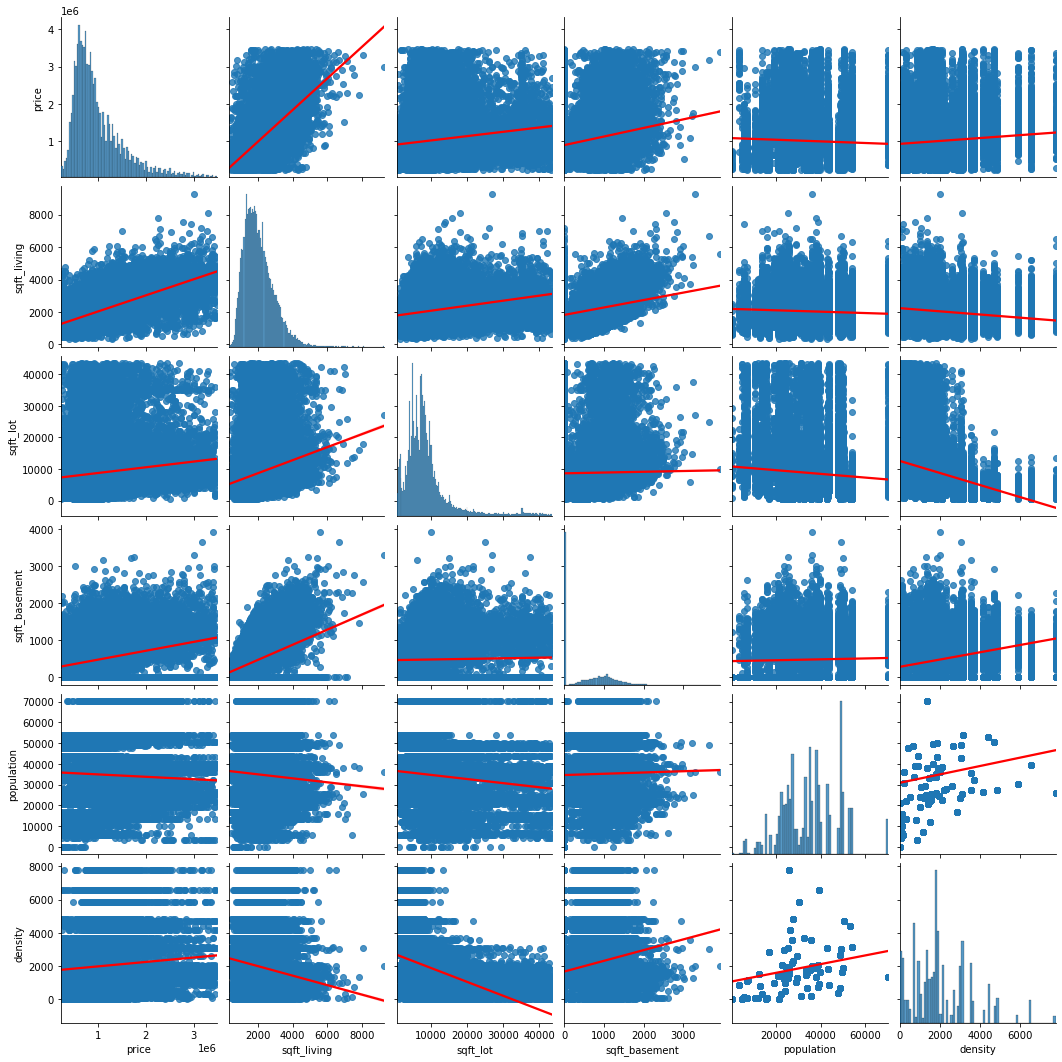

In [26]:
dm.pair_viz(df)

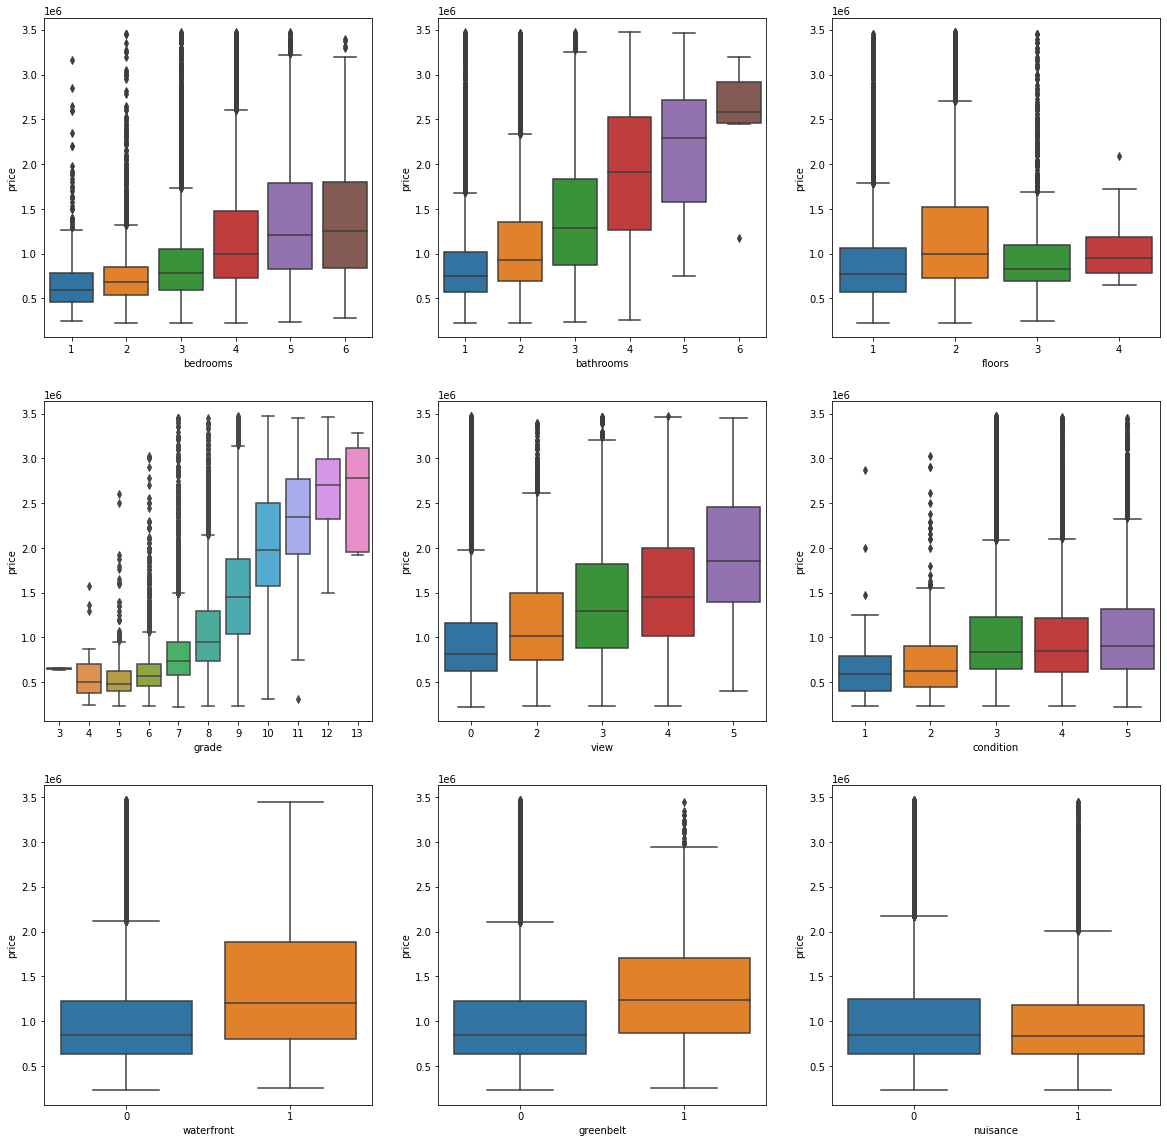

In [27]:
dm.box_viz(df)

Based on this, the most promising features are `sqft_living`, `grade`, `bathrooms`, `bedrooms`, `view`, `sqft_basement`, `waterfront` and `greenbelt`. I also decided to include `zipcode`, to account for changes in price based on location of the property.

Before proceding with the model, I created a heatmap to check for multicollinerity between the predictors. 

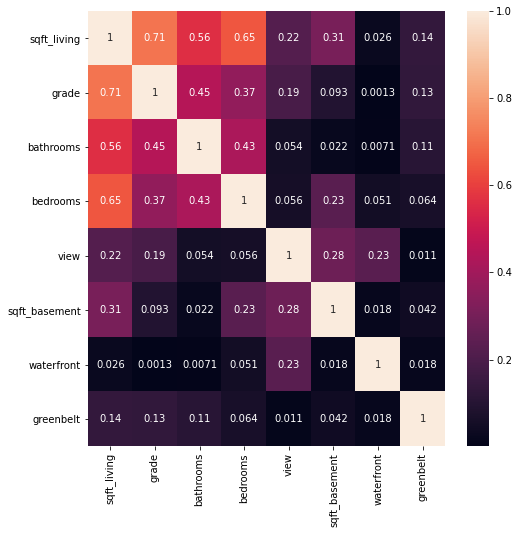

In [28]:
dm.heat_viz(df)

Since `grade` and `sqft_living` have a correlation of greater than 0.7, I had to choose between the two of them. I decided to omit `grade` as it had a slightly lower correlation with `price`

### Baseline Model
Since `sqft_living` is the feature with the strongest correlation, I will use this for my baseline model.<br> 
**Target Variable:** price <br> 
**Predictor Variable:** sqft_living

In [29]:
baseline_results, baseline_df = dm.baseline(df)
baseline_df

,num_features,r2_adj,f_pvalue,MAE,large_pvals,cond_num
0,2,42.05%,0.0,"$305,263",0,5827.95


### Recursive Feature Elimination
To begin my model iteration, I included all of the relevant features. Then I removed one feature at a time starting with any feature with a p-value larger than 0.01. Then I removed the feature with the smallest absolute coefficient as that means it has the least effect of `price`. I used the adjusted R-squared value, Mean Absolute Error, and Conditional Number to judge the model and help me decide when to stop removing features. I have also normalized each numeric feature to make it easier to compare their coefficients. 

Here is a table which includes the records the metrics for each iteration as well as what changed between each iteration. 

**Target Variable:** price <br> 
**Predictor Variables:**
- sqft_living_norm 
- bathrooms_norm
- bedrooms_norm 
- view_norm
- sqft_basement_norm
- greenbelt
- waterfront
- zipcode

In [30]:
dm.RFE_df(df)

,num_features,r2_adj,f_pvalue,MAE,large_pvals,cond_num,dropped
0,82,73.5%,0.0,"$191,949",6,96.50,None
1,76,73.5%,0.0,"$191,907",0,70.08,"zipcode_98019, zipcode_98045, zipcode_98106, z..."
2,75,73.46%,0.0,"$192,001",0,62.08,bedrooms_norm
3,74,73.42%,0.0,"$192,065",0,57.97,bathrooms_norm
4,73,72.93%,0.0,"$193,309",2,51.68,sqft_basement_norm
5,71,72.93%,0.0,"$193,317",0,49.55,"zipcode_98014, zipcode_98051"
6,70,72.02%,0.0,"$196,704",1,45.15,view_norm
7,69,72.02%,0.0,"$196,702",0,45.13,zipcode_98070
8,68,72.0%,0.0,"$196,785",0,45.12,greenbelt
9,67,71.96%,0.0,"$196,968",0,45.07,zipcode_98133


### Final Model
I decided to have my final model be the step where `greenbelt` was dropped (index = 8) because the the Adjusted R-Squared was high, the Mean Absolute Error was relatively low, and the Conditional Number didn't seem to improve much as the iteration continued. 

**Target Variable:** price <br>
**Predictor Variables:** sqft_living_norm, waterfront, and 65 different zip codes.

In [31]:
final_results, final_df = dm.final_res(df)
final_df

,num_features,r2_adj,f_pvalue,MAE,large_pvals,cond_num
0,68,72.0%,0.0,"$196,785",0,45.12


## Evaluation

In [32]:
baseline_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.420
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                 3.452e+04
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:18:30   Log-Likelihood:            -6.8301e+05
No. Observations:               47579   AIC:                         1.366e+06
Df Residuals:                   47577   BIC:                         1.366e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        1.457e+05   5024.446     28.998      0.000    1.36e+05    1.56e+05
sqft_living   422.8334      2.276    185.792      0.000     418.373     427.294
==============================================================================
Omnibus:                     9411.902   Durbin-Watson:                   0.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            27262.552
Skew:                           1.042   Prob(JB):                         0.00
Kurtosis:                       6.067   Cond. No.                     5.83e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.83e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Baseline Interpretation Model
The baseline model is statistically significant and explains about 42% of the variance in price. In a typical prediction, the model is off by about \\$305k.

The intercept is at about \\$145,700. This means that a house with the zero square footage of living space in the home would sell for \\\$145,700.
The coefficient for `sqft_living` is about \\$423. This means for each increase of 1 square foot of living space in the home, we see an associated increase of about \\$423.

***

In [33]:
final_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     1827.
Date:                Wed, 28 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:18:30   Log-Likelihood:            -6.6568e+05
No. Observations:               47579   AIC:                         1.331e+06
Df Residuals:                   47511   BIC:                         1.332e+06
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              8.53e+05   3983.380    214.150      0.000    8.45e+05    8.61e+05
sqft_living_norm  2.927e+05   1437.294    203.642      0.000     2.9e+05    2.96e+05
waterfront        4.813e+05   1.27e+04     37.989      0.000    4.56e+05    5.06e+05
zipcode_98001    -2.487e+05   1.02e+04    -24.291      0.000   -2.69e+05   -2.29e+05
zipcode_98002    -2.097e+05   1.24e+04    -16.931      0.000   -2.34e+05   -1.85e+05
zipcode_98003    -2.099e+05    1.1e+04    -19.015      0.000   -2.32e+05   -1.88e+05
zipcode_98004     1.182e+06   1.68e+04     70.218      0.000    1.15e+06    1.22e+06
zipcode_98005      7.79e+05   1.87e+04     41.676      0.000    7.42e+05    8.16e+05
zipcode_98006     5.727e+05   1.04e+04     54.834      0.000    5.52e+05    5.93e+05
zipcode_98007      4.71e+05   1.85e+04     25.399      0.000    4.35e+05    5.07e+05
zipcode_98008     5.324e+05   1.18e+04     44.926      0.000    5.09e+05    5.56e+05
zipcode_98010    -2.444e+05   1.54e+04    -15.881      0.000   -2.75e+05   -2.14e+05
zipcode_98011     1.991e+05   1.36e+04     14.597      0.000    1.72e+05    2.26e+05
zipcode_98022    -2.242e+05   1.32e+04    -17.033      0.000    -2.5e+05   -1.98e+05
zipcode_98023    -2.465e+05   9139.335    -26.971      0.000   -2.64e+05   -2.29e+05
zipcode_98024     1.161e+05   2.89e+04      4.023      0.000    5.95e+04    1.73e+05
zipcode_98027     2.917e+05   1.35e+04     21.637      0.000    2.65e+05    3.18e+05
zipcode_98028     1.205e+05   1.25e+04      9.625      0.000     9.6e+04    1.45e+05
zipcode_98029     4.008e+05   1.36e+04     29.391      0.000    3.74e+05    4.28e+05
zipcode_98030    -2.111e+05   1.24e+04    -16.986      0.000   -2.35e+05   -1.87e+05
zipcode_98031    -1.883e+05   1.09e+04    -17.314      0.000    -2.1e+05   -1.67e+05
zipcode_98032    -1.914e+05   1.69e+04    -11.293      0.000   -2.25e+05   -1.58e+05
zipcode_98033     8.303e+05   1.03e+04     80.974      0.000     8.1e+05     8.5e+05
zipcode_98034     3.066e+05   9331.977     32.852      0.000    2.88e+05    3.25e+05
zipcode_98038    -1.528e+05   9121.319    -16.757      0.000   -1.71e+05   -1.35e+05
zipcode_98039     1.724e+06    5.2e+04     33.166      0.000    1.62e+06    1.83e+06
zipcode_98040     9.328e+05   1.37e+04     67.954      0.000    9.06e+05     9.6e+05
zipcode_98042    -2.172e+05   8415.376    -25.807      0.000   -2.34e+05   -2.01e+05
zipcode_98047     -1.95e+05   2.48e+04     -7.859      0.000   -2.44e+05   -1.46e+05
zipcode_98052     5.093e+05   9921.237     51.337      0.000     4.9e+05    5.29e+05
zipcode_98053     3.385e+05   1.36e+04     24.877      0.000    3.12e+05    3.65e+05
zipcode_98055    -1.561e+05   1.57e+04     -9.926      0.000   -1.87e+05   -1.25e+05
zipcode_98056     7.316e+04   1.09e+04      6.714      0.000    5.18e+04    9.45e+04
zipcode_98057    -9.793

#### Final Model Interpretation

The final model is statistically significant and explains about 72% of the variance in price, a large improvement over the original 42%. The Mean Absolute Error has also improved from \\$305k to \\$197k.

The intercept is at about \\$865,700. This represents the predicted price of a property with the average square footage of living space, not on a waterfront, and in a King County zip code not included in our model. 

The coefficient for `sqft_living_norm` is about \\$292,100. This means for each increase of 1 standard deviation of square foot of living space in the home, we see an associated increase of about \\$292,100. Since the standard deviation of `sqft_living` is about 836, for every increase of 1 square foot of living space, we can expect and increase of about \\$349 in sale price. 

The coefficient for `waterfront` is about \\$480,200, which means we can expect a home on a waterfront to have an increase in sales price of \\$480,200. 

Since we have 65 `zipcode` features, it would be more helpful describe their overall shape than to go one by one. Each `zipcode` coefficient represents the predicted change in sale price for properties located within that zip code.

All of the coefficients are statistically significant.

In [34]:
zips = final_results.params[3:]
zips.describe()

count    6.500000e+01
mean     2.021175e+05
std      3.871906e+05
min     -2.645760e+05
25%     -1.528454e+05
50%      1.990979e+05
75%      4.614884e+05
max      1.724380e+06
dtype: float64

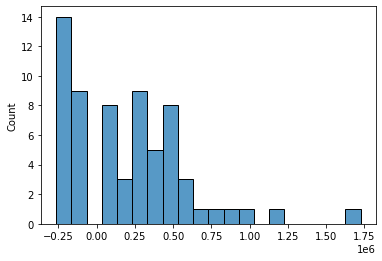

In [35]:
sns.histplot(zips, bins = 20);

The distribution of the zip codes skews right, with with most zip codes changing the sale price from about -\\$250,000 to \\$500,000 and a handfull of zip codes that raise the price of a home significantly up to \\$1,711,924.

### Model Evaluation
Let's check our assumptions when using linear regression to determine the validity our final model.  

First, I will see if the there is a linear relationship between our predictors and target by plotting the residuals and conducting a Rainbow Test.

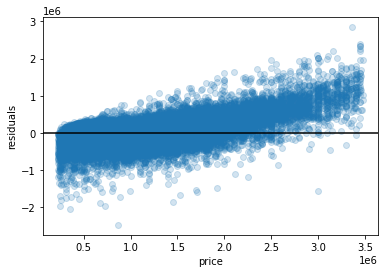

In [36]:
fig,ax = plt.subplots()
plt.scatter(df["price"], final_results.resid, alpha=0.2)
plt.axhline(y=0, color="black")
ax.set_xlabel("price")
ax.set_ylabel("residuals")
plt.show();

In [37]:
# Rainbow Test
sm.stats.diagnostic.linear_rainbow(final_results)[1]

0.0002345889507682023

Since the residual plot does seem to be slightly curved and the p-value of the Rainbow hypothesis test was below 0.05, we cannot conclude that there is a linear relationship. 

Additionally, as shown by the q-q plot below, the residuals are not completely distributed normally. 

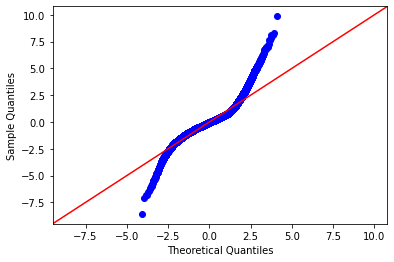

In [38]:
fig, ax = plt.subplots()
sm.graphics.qqplot(final_results.resid, dist=stats.norm, line='45', fit=True, ax=ax)
plt.show();

Since our model fails at two of the assumptions underlying linear regression, we cannot be  be confident in it's results, despite the high R-squared value. 

## Conclusion
Based on our final model, the three features which best determine sale price are:
* **sqft_living** - Square footage of living space in the home
* **waterfront** - Whether the house is on a waterfront
* **zipcode** - The 5-digit zip code assigned by the U.S. Postal Service. Only includes zip codes in King County, WA.

I would advise the startup to gather these three pieces of data for houses currently on the market in King County, WA and recommend houses where the sale price is below what our model would determine.  

### Limitations
There does not appear to be a linear relationship between our predictor and target variables. The residuals of our final model are also not normally distributed. Failing these two assumptions for linear regression should cast doubt as to the results of the model. This indicates that there are likely other factors that affect price which are not included in the model.

Despite including more data than the original dataset, we are still limited by our dataset, which doesn't include other factors in determining price, such as the federal interest rate at the time of the sale, housing availability, and other qualities of the neighborhood where each property is located. 

### Next Steps
Based on this project's limitations, I would recommend we:
- gather more data to include other factors that determine sale price and
- create new models with include interaction variables to account for the potential non-linear relationship between variables
